In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random 
import re
import preprocessor as p


In [3]:
#chunksize = 10 ** 8

#btcdata = pd.read_csv('../data/interim/copy/bitcoin_engage_tweets_search_result_temp.csv')
#btcdata = pd.read_csv('../data/raw/btc-tweets-2016-2019/tweets.csv', sep='delimiter', header=None, low_memory=False)
#btcdata = pd.read_csv('../data/interim/bitcoin_all_tweets_search_result.csv')
#btcTrainData = pd.read_csv('../data/interim/bitcoin_all_tweets_search_result_20211001-20220130.csv')

btcTrainData = pd.read_csv('../data/interim/bitcoin_all_tweets_search_result_20210101-20210930.csv')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0,4,5,6,8,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:

btcTrainData = btcTrainData[['id', 'date', 'text', 'hashtags', 'replyCount', 'retweetCount',
'likeCount', 'userName', 'userFollowerCount', 'userFavCount', 'userFriendCount']]
print(btcTrainData.shape)
btcTrainData.info()


(20357616, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20357616 entries, 0 to 20357615
Data columns (total 11 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   id                 object
 1   date               object
 2   text               object
 3   hashtags           object
 4   replyCount         object
 5   retweetCount       object
 6   likeCount          object
 7   userName           object
 8   userFollowerCount  object
 9   userFavCount       object
 10  userFriendCount    object
dtypes: object(11)
memory usage: 1.7+ GB


In [5]:
#Remove duplicates based on the id
print('before dropping duplicate by id:' , btcTrainData.shape)
btcTrainData = btcTrainData.drop_duplicates(subset=['id'], keep='first')
print('after dropping duplicate by id:' , btcTrainData.shape)


before dropping duplicate by id: (20357616, 11)
after dropping duplicate by id: (20357288, 11)


In [6]:
#convert type of numeric fields
btcTrainData['replyCount'] = pd.to_numeric(btcTrainData['replyCount'], errors='coerce')
btcTrainData['retweetCount'] = pd.to_numeric(btcTrainData['retweetCount'], errors='coerce')
btcTrainData['likeCount'] = pd.to_numeric(btcTrainData['likeCount'], errors='coerce')
btcTrainData['userFollowerCount'] = pd.to_numeric(btcTrainData['userFollowerCount'], errors='coerce')
btcTrainData['userFavCount'] = pd.to_numeric(btcTrainData['userFavCount'], errors='coerce')
btcTrainData['userFriendCount'] = pd.to_numeric(btcTrainData['userFriendCount'], errors='coerce')

#convert type of text fields
btcTrainData['text'] = btcTrainData['text'].astype("string")

#btcdata = btcdata.astype({
    #"userFollowerCount": "int",
    #"userFavCount": "int",
    #"userFriendCount": "int",
    #"replyCount": "int",
    #"retweetCount": "int",
    #"likeCount": "int"
    #}) 


#btcdata.describe().apply(lambda s: s.apply('{0:.5f}'.format))



In [7]:
#converting to datetime from string
btcTrainData["dateTime"] = pd.to_datetime(btcTrainData["date"], format="%Y-%m-%d %H:%M:%S", errors='coerce')

#to get rows from a period of time using dateTime
#btcTrainData = btcTrainData[(btcTrainData['dateTime'] > '2021-08-01') & (btcdata['dateTime'] < '2021-09-01')]
btcTrainData = btcTrainData[btcTrainData['dateTime'] >= '2021-02-01']



In [8]:
btcTrainData['text'] = btcTrainData['text'].apply(lambda x: x.lower()) #transform text to lowercase

data = btcTrainData

In [9]:
#btcdata.shape
#drop tweets with missing data
print('before drop by na')
print(data.shape)
print('after drop by na')
data = data.dropna(subset=['replyCount', 'retweetCount', 'likeCount', 'userFollowerCount', 'userFavCount', 'userFriendCount'])
print(data.shape)




before drop by na
(18226843, 12)
after drop by na
(18226843, 12)


In [10]:
#dropping the tweets from users with no followers, friends and favourites
print('before dropping invalid users:' , data.shape)
data = data[~((data["userFollowerCount"] == 0) & (data["userFavCount"] == 0) & (data["userFriendCount"] == 0))]
#data = data.drop(data[(data["user_followers"] == 0) | (data["user_friends"] == 0) | (data["user_favourites"] == 0)].index)
print('after dropping invalid users:', data.shape)


before dropping invalid users: (18226843, 12)
after dropping invalid users: (18220667, 12)


In [11]:
#dropping the tweets with suspicious hashtags, words, bigrams, and trigrams

#any(substring in string for substring in substring_list)

#hashtags
print('before dropping by hashtags:' , data.shape)
data = data[~data.text.str.contains('#freecrypto|#freemoney|#freebitcoin|#freebtc')]
print('after dropping by hashtags:' , data.shape)

#words
print('before dropping by single keyword:' , data.shape)
data = data[~data.text.str.contains('entertaining|subscribe')]
print('after dropping by single keyword:' , data.shape)

#bigrams
print('before dropping by bigrams:' , data.shape)
data = data[~(data.text.str.contains('free bitcoin|current price|bitcoin price|earn bitcoin'))]
print('after dropping by bigrams:' , data.shape)
#data = data[~(data.text.str.contains('current') & (data.text.str.contains('price')))]
#data = data[~(data.text.str.contains('bitcoin') & (data.text.str.contains('price')))]
#data = data[~(data.text.str.contains('earn') & (data.text.str.contains('bitcoin')))]

#trigrams
print('before dropping by trigrams:' , data.shape)
data = data[~(data.text.str.contains('start trading bitcoin'))]
print('after dropping by trigrams:' , data.shape)


before dropping by hashtags: (18220667, 12)
after dropping by hashtags: (18207303, 12)
before dropping by single keyword: (18207303, 12)
after dropping by single keyword: (18178584, 12)
before dropping by bigrams: (18178584, 12)
after dropping by bigrams: (17853606, 12)
before dropping by trigrams: (17853606, 12)
after dropping by trigrams: (17853271, 12)


In [12]:
#Remove urls, mentions, hashtags, empty lines, spaces, reserved words (RT, FAV)
#keep emojis, smileys, numbers
p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.HASHTAG, p.OPT.RESERVED)
data['text'] = data['text'].apply(lambda x: p.clean(x))



In [13]:
#Check the header of formated text
data.text[100:200]


101    that is going to be a lovely office. anyway, l...
102     cryptocurrencies are eating straws in your heart
103                                 join me in my space!
104    american hodlers should be taking advantage of...
105    october is projected to be the start of the cr...
                             ...                        
198    is very high quality and reliable platform. th...
199    just reporting the stats, it is the part of sc...
200    cryptocurrency ransomware payments rose by 300...
201    probably the most intelligent take on bitcoin ...
202    forex trading: what is forex? fx trading expla...
Name: text, Length: 100, dtype: object

In [14]:
#save the length of each tweets to df
data['textLength'] = data['text'].str.len()

Verify data integrity


In [15]:
# Select all duplicate rows based on one column
#duplicateRowsDF = data[data.duplicated(['id'])]

#print("Duplicate Rows based on a single column are:", duplicateRowsDF, sep='\n')
##duplicateRowsDF

#Numbers of duplicate rows in each date
#duplicateRowsDFDate = duplicateRowsDF['dateTime'].groupby(duplicateRowsDF['dateTime'].dt.date)
#duplicateRowsDFDate.size()
print(data.shape)

#check if all the text are string
data[data['text'].map(type) == str].shape 



(17853271, 13)


(17853271, 13)

Save processed data


In [16]:
#save the processed data to csv
#data.to_csv('../data/processed/bitcoin_tweets_result_processed_20211001-20220130.csv')


Display histograms of tweets length


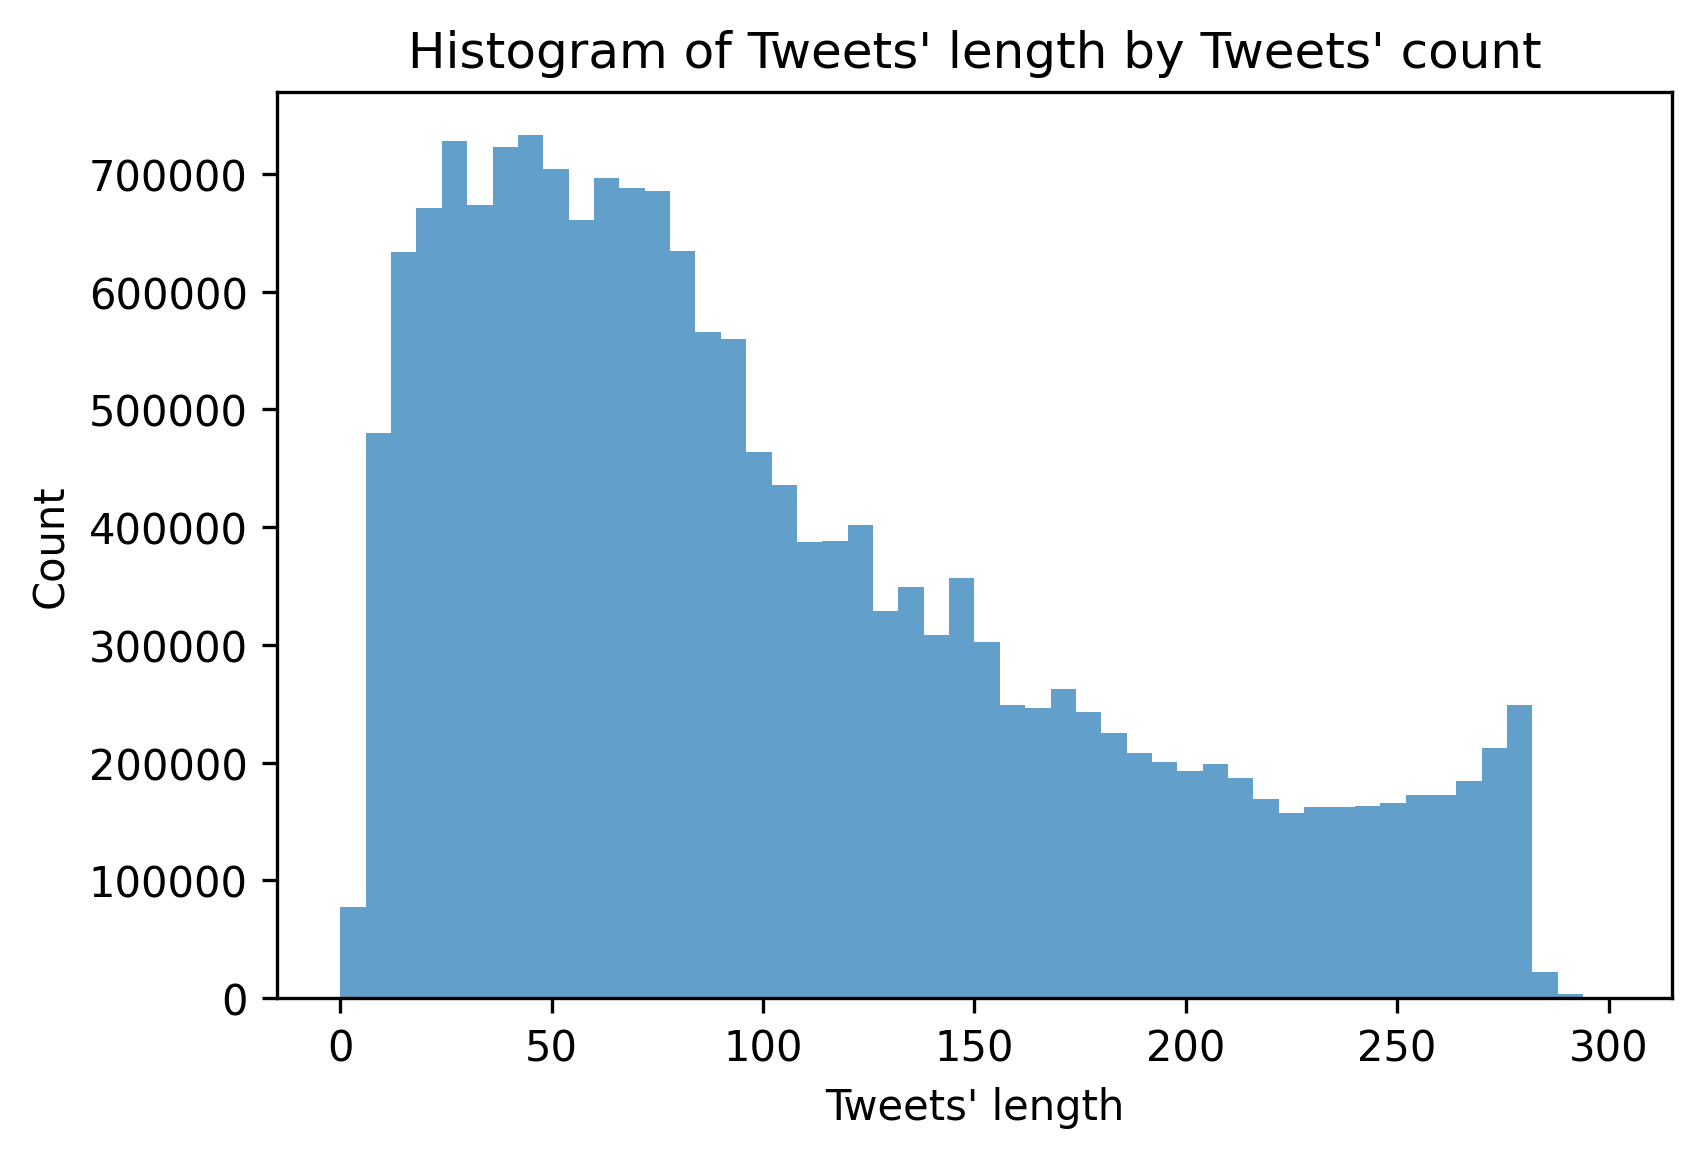

In [36]:
#display histograms of tweets length
#cols = ["user_followers", "user_friends", "user_favourites"]

#for col in cols:
col = "textLength"
#btcdata = btcdata.astype({"user_friends": "float64"}) #Conv datatype of df3, user_followers Col from object to int64
#pos_series = btcdata[col].tolist()
#neg_series = negative_examples[col].tolist()
plt.figure(dpi=300)
plt.hist(data[col], 50, alpha=0.7, range=(0,300))
#plt.hist(neg_series, 50, facecolor='r', alpha=0.7, label="0")
#plt.legend(prop={"size": 10})
plt.xlabel("Tweets' length", color='#000000')
plt.ylabel("Count", color='#000000')
plt.ticklabel_format(style='plain')
plt.tick_params(labelcolor='#000000')
plt.title("Histogram of Tweets' length by Tweets' count", color='#000000')
plt.show()

Check the total number of tweets for each day, overlay with bitcoin closing price


In [18]:
#load bitcoin pricing information
price = pd.read_csv('../data/external/BTC_USD_2020-10-10_2021-10-09-CoinDesk.csv')
pdata = price[['Date', 'Closing Price (USD)']]

In [19]:
#count number of tweets each date
df = data['dateTime'].groupby(data['dateTime'].dt.date).size().reset_index(name='count')

In [20]:
#merge two dfs by date


df = df.astype({"dateTime": "str"}) 
print(type(df['dateTime'][0]))
#print(type(pdata['Date'][0]))

#merged_df1 = pd.merge(left=df, right=pdata, left_on='dateTime', right_on='Date')
#merged_df1 = merged_df1.astype({"Closing Price (USD)": "int"}) 
#merged_df1

<class 'str'>


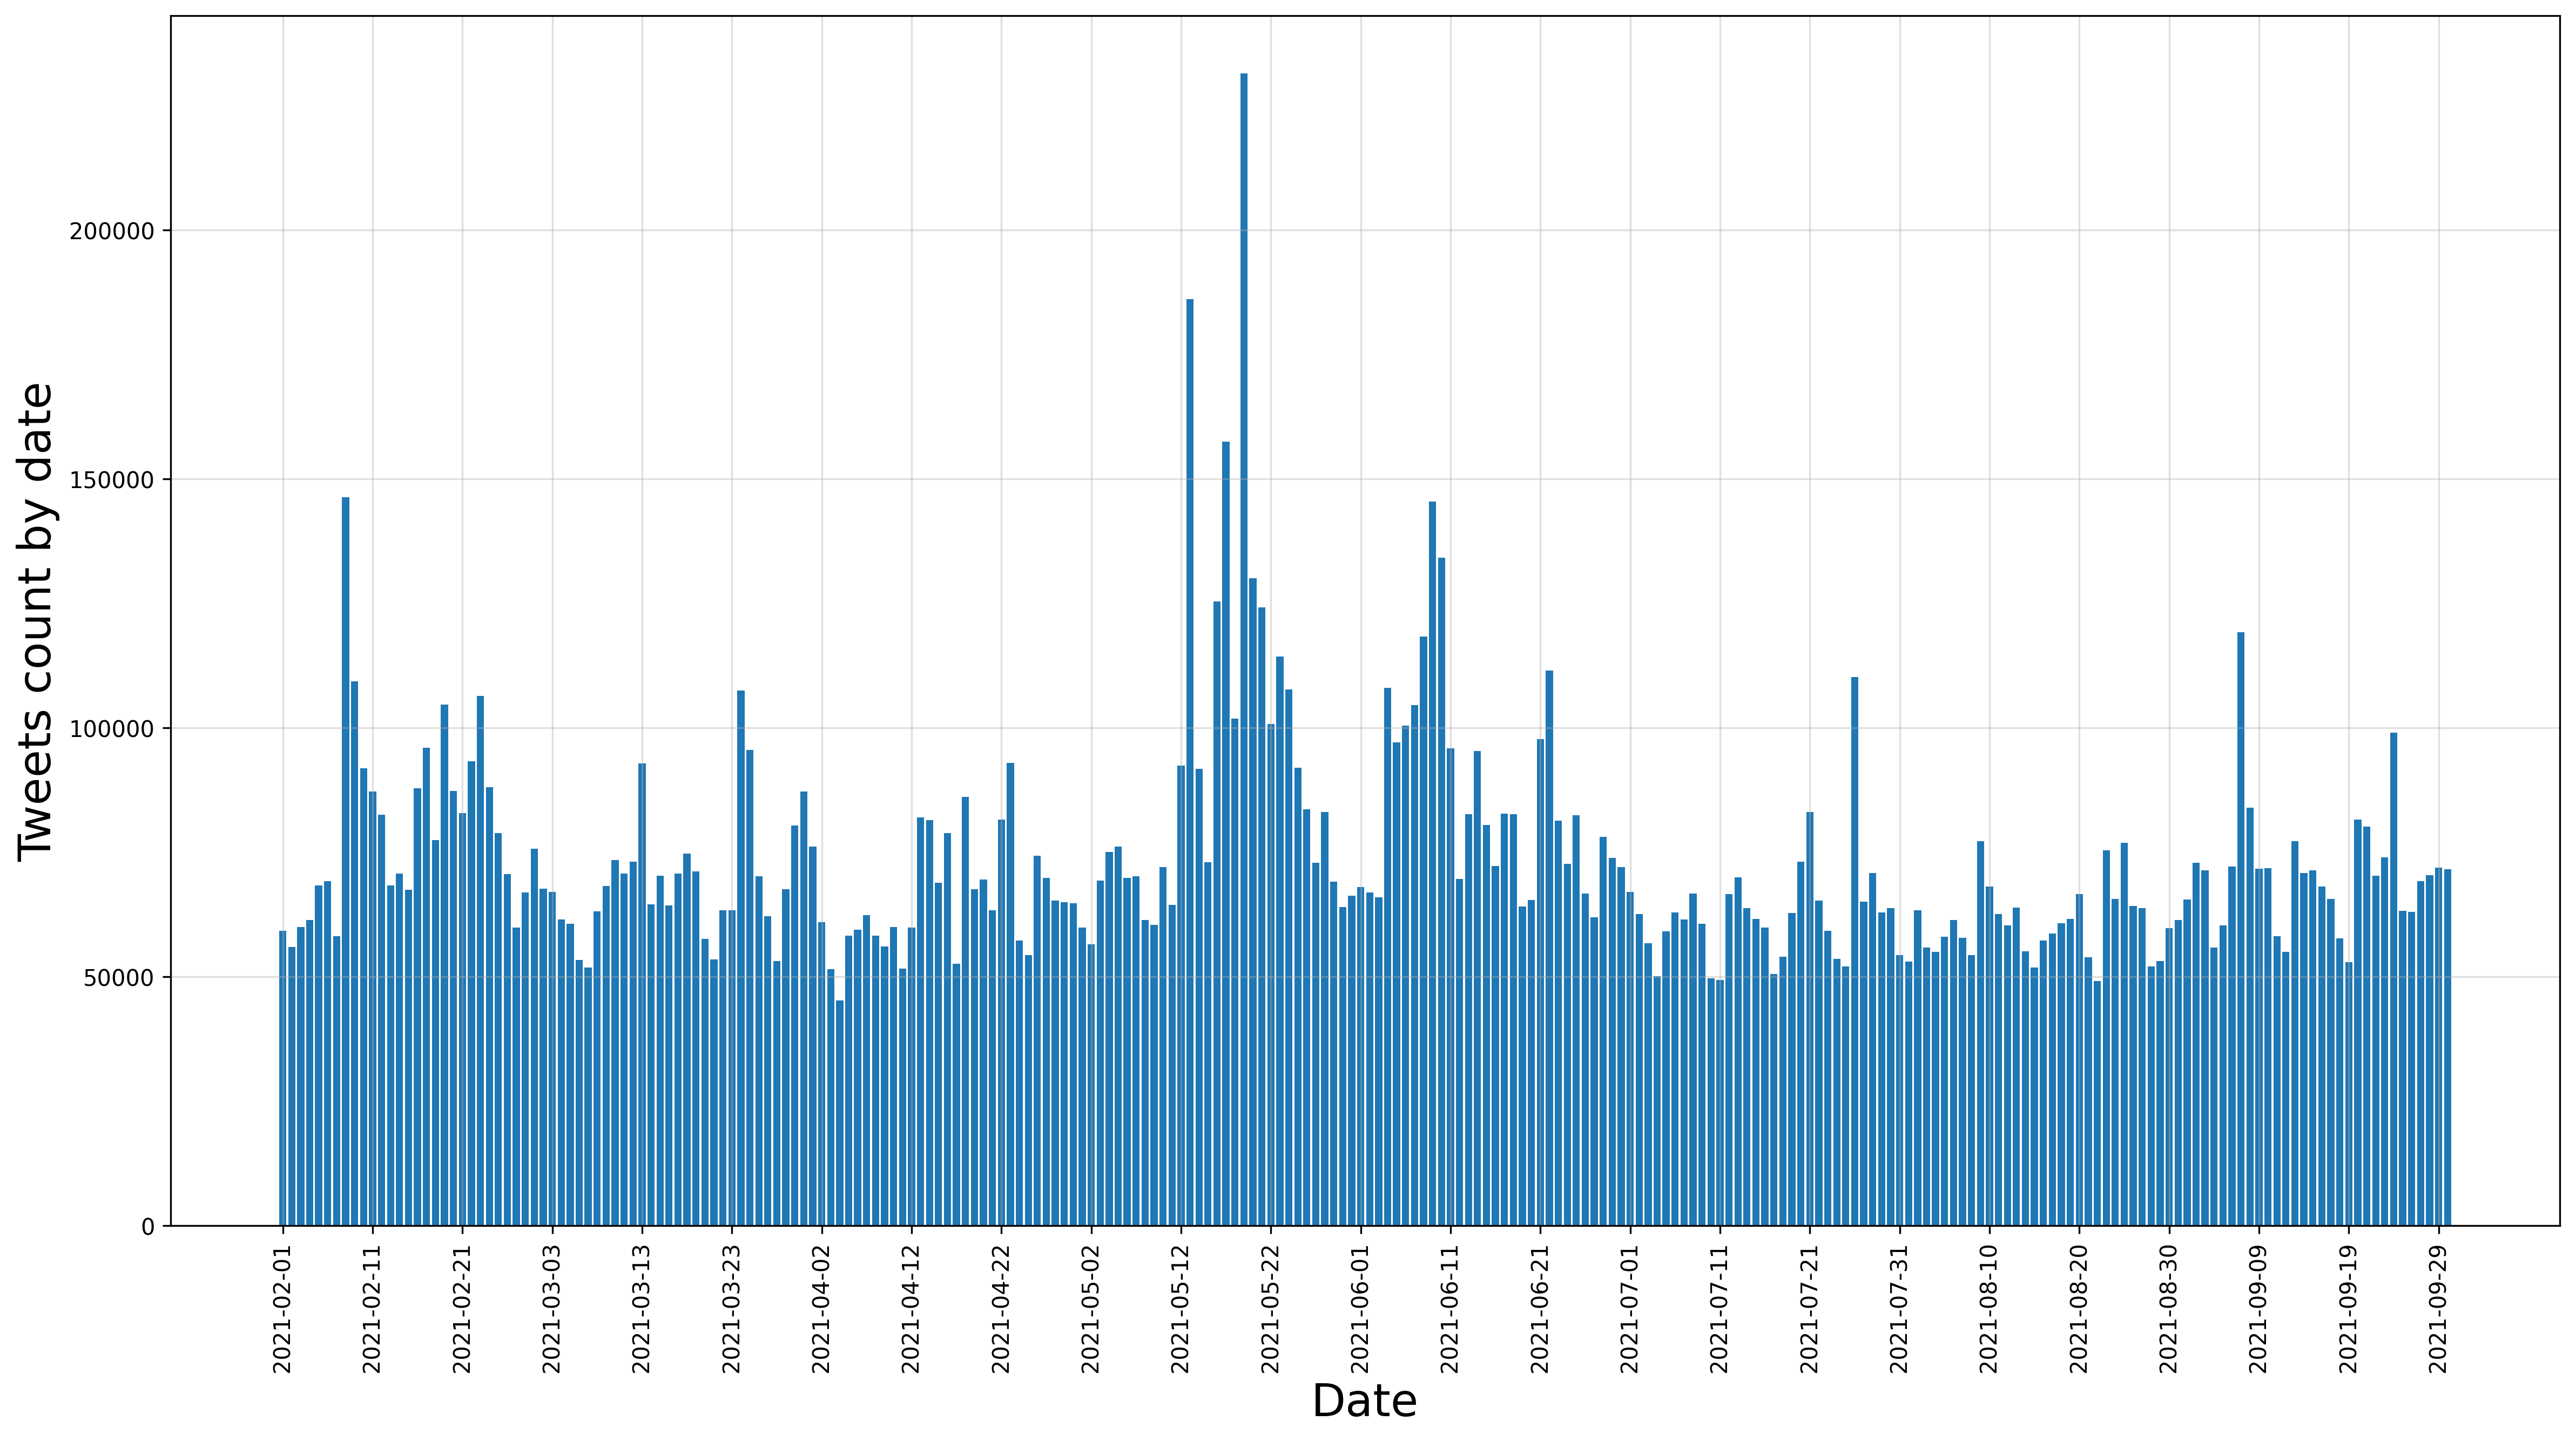

In [37]:
#x = merged_df1['dateTime']
#y1 = merged_df1['count']
#y2 = merged_df1['Closing Price (USD)']

x = df['dateTime']
y1 = df['count']

# Plot Line1 (Left Y Axis)
fig, ax1 = plt.subplots(1,1,figsize=(16,9), dpi= 300)
ax1.bar(x, y1) #color='tab:red')


# Plot Line2 (Right Y Axis)
#ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
#ax2.plot(x, y2, color='tab:blue')

# Decorations
# ax1 (left Y axis)
ax1.set_xlabel('Date', fontsize=20)
ax1.tick_params(axis='x', rotation=0, labelsize=12)
ax1.set_ylabel('Tweets count by date', fontsize=20) #color='tab:red')
ax1.tick_params(axis='y', rotation=0) #labelcolor='tab:red' )
ax1.grid(alpha=.4)

ax1.set_xticks(np.arange(0, len(x), 10)) #change this number to change the number of labels
ax1.set_xticklabels(x[::10], rotation=90, fontdict={'fontsize':10}) #change this number to change the number of labels

# ax2 (right Y axis)
#ax2.set_ylabel("Bitcoin closing price (USD)", color='tab:blue', fontsize=20)
#ax2.tick_params(axis='y', labelcolor='tab:blue')
#ax2.set_xticks(np.arange(0, len(x), 20)) #change this number to change the number of labels
#ax2.set_xticklabels(x[::20], rotation=90, fontdict={'fontsize':10}) #change this number to change the number of labels
#ax2.set_title("Personal Savings Rate vs Unemployed: Plotting in Secondary Y Axis", fontsize=22)
fig.tight_layout()
plt.show()




Randomly select rows from each day


In [26]:
#btcdata.groupby(btcdata['date_time'].dt.year).apply(lambda x :x.iloc[random.choice(range(0,len(x)))])
#btcdata.groupby(btcdata['date_time'].dt.year).apply(lambda x: x.sample(2)).reset_index(drop=True)

selected = data.groupby(data['dateTime'].dt.day).apply(lambda x: x.sample(10, random_state=889))

selected.to_csv('sample_bitcoin_tweets_ten_each_day.csv')
selected

id                       date  \
dateTime                                                            
1        13692201  1377597361925488640  2021-04-01 12:23:00+00:00   
         8744272   1399561775612313600  2021-06-01 03:01:44+00:00   
         4082689   1421767398122692612  2021-08-01 09:38:57+00:00   
         15922826  1366210853754859520  2021-03-01 02:17:05+00:00   
         15885194  1366406691860844545  2021-03-01 15:15:16+00:00   
...                                ...                        ...   
31       2206999   1432712548365778949  2021-08-31 14:31:04+00:00   
         4104504   1421597723808174085  2021-07-31 22:24:44+00:00   
         8753842   1399502450030268418  2021-05-31 23:06:00+00:00   
         4141074   1421365200108806147  2021-07-31 07:00:46+00:00   
         2183444   1432831121813876736  2021-08-31 22:22:14+00:00   

                                                                text  \
dateTime                                                               
1        13692201  goldman sachs is close to offering bitcoin and...   
         8744272   exchanges could fix that if they stop pairing ...   
         4082689          $btc head and shoulder on the 1 hour chart   
         15922826  newsflash, anytime bitcoin is purchased its be...   
         15885194  hurry! 2.70% intra-loop arbitrage in . the max...   
...                                                              ...   
31       2206999   📉💶$4,293,569 $btc shorted $47520.0 [31/08/21 1...   
         4104504   stock to flow (s2f) 📈 bullish indication relat...   
         8753842                                           autoglyph   
         4141074   this provision could redefine a coffee shop ow...   
         2183444                     break out for what? btc?? eth??   

                                                            hashtags  \
dateTime                                                               
1        13692201                                                NaN   
         8744272                                                 NaN   
         4082689                                                 NaN   
         15922826                                                NaN   
         15885194  ['ENJ', 'CoinDCX', 'crypto', 'arbitrage', 'koi...   
...                                                              ...   
31       2206999                                                 NaN   
         4104504                                  ['Bitcoin', 'BTC']   
         8753842   ['ethereum', 'bitcoin', 'binance', 'crypto', '...   
         4141074                                         ['bitcoin']   
         2183444                                                 NaN   

                   replyCount  retweetCount  likeCount        userName  \
dateTime                                                                 
1        13692201         0.0           0.0        3.0       GaltsGirl   
         8744272          0.0           0.0        2.0   Jason39336330   
         4082689          1.0           0.0        0.0          5Mu5hy   
         15922826         0.0           0.0        0.0  ayyylmaobruhhh   
         15885194         0.0           0.0        0.0      KoinKnight   
...                       ...           ...        ...             ...   
31       2206999          0.0           1.0        5.0     WhaleTrades   
         4104504          1.0           0.0        0.0  CoinIndication   
         8753842          0.0           1.0        0.0        arel_btc   
         4141074          0.0           0.0        1.0         v4pedro   
         2183444          0.0           0.0        0.0    Deon32970609   

                   userFollowerCount  userFavCount  userFriendCount  \
dateTime                                                              
1        13692201            42468.0        6916.0           5183.0   
         8744272               926.0       44338.0           1053.0   
         4082689 